# Библиотеки

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3 MB 4.2 MB/s 


## Загрузка и распаковка датасета KTH

In [4]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

--2021-12-20 11:54:24--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2021-12-20 11:54:25--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   475KB/s    in 8m 20s  

2021-12-20 12:02:46 (474 KB/s) - ‘walking.zip’ saved [242442411/242442411]

--2021-12-20 12:02:47--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.s

# Подготовка датасета для классификации

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


# Разбивка данных на батчи

In [6]:
random.shuffle(dataset)

In [12]:
dataset[:10]

[('./handclapping/person19_handclapping_d2_uncomp.avi', 5),
 ('./walking/person25_walking_d1_uncomp.avi', 0),
 ('./jogging/person23_jogging_d4_uncomp.avi', 1),
 ('./handwaving/person20_handwaving_d3_uncomp.avi', 4),
 ('./handwaving/person20_handwaving_d4_uncomp.avi', 4),
 ('./jogging/person20_jogging_d1_uncomp.avi', 1),
 ('./jogging/person01_jogging_d3_uncomp.avi', 1),
 ('./jogging/person16_jogging_d4_uncomp.avi', 1),
 ('./walking/person06_walking_d3_uncomp.avi', 0),
 ('./handwaving/person16_handwaving_d4_uncomp.avi', 4)]

In [15]:
new_dataset = []
n = 5
for i in range(0, len(dataset), n):
    if n + 5 < len(dataset):
        new_dataset.append(dataset[i:i+n])

# Разбивка данных на валидационные и тренировачные

In [17]:
len(new_dataset)

120

In [18]:
train = new_dataset[:100]

In [19]:
test = new_dataset[100:]

# Создание модели

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

# Подготовка к обучению

In [21]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

# Цикл обучения

In [90]:
# fix ValueError: Creating variables on a non-first call to a function decorated with tf.function.
tf.config.experimental_run_functions_eagerly(True)

In [91]:
tf.config.run_functions_eagerly(True)

In [92]:
with tf.device('/device:GPU:2'):
    global_step = 0
    for ep in range(NUM_EPOCHS):
        for iter, batch in enumerate(train):
            X_train = []
            y_train = []
            for idx, (fpath, label) in enumerate(batch):
                videodata = skvideo.io.vread(fpath)
                videodata = videodata.astype(np.float32) / 255.
                motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
                y = np.array(label)
                X_train.append(motion[:200])
                y_train.append(y)
            X_train = np.stack(X_train)
            y_train = np.array(y_train)
            # X_train = tf.convert_to_tensor(X_train , np.float32)
            # y_train = tf.convert_to_tensor(y_train , np.float32)
            loss_value = model.train_on_batch(X_train, y_train)

            if iter % 10 == 0:
                # test_on_batch method - for validation
                print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(train)}] Loss = {loss_value}')

                with writer.as_default():
                    tf.summary.scalar('loss', loss_value, global_step)

            global_step += 1

[0/10][0/100] Loss = 1.755128264427185
[0/10][10/100] Loss = 1.789044737815857
[0/10][20/100] Loss = 1.7926874160766602
[0/10][30/100] Loss = 1.7886167764663696
[0/10][40/100] Loss = 1.833980917930603
[0/10][50/100] Loss = 1.9494985342025757
[0/10][60/100] Loss = 1.4681694507598877
[0/10][70/100] Loss = 1.241463541984558
[0/10][80/100] Loss = 1.3052661418914795
[0/10][90/100] Loss = 1.3422490358352661
[1/10][0/100] Loss = 0.8854821920394897
[1/10][10/100] Loss = 0.9204837679862976
[1/10][20/100] Loss = 2.1908698081970215
[1/10][30/100] Loss = 0.9287745356559753
[1/10][40/100] Loss = 1.1773055791854858
[1/10][50/100] Loss = 0.944534182548523
[1/10][60/100] Loss = 0.6569337844848633
[1/10][70/100] Loss = 0.46204715967178345
[1/10][80/100] Loss = 0.5557540655136108
[1/10][90/100] Loss = 0.8478168249130249
[2/10][0/100] Loss = 0.6711967587471008
[2/10][10/100] Loss = 0.3048005998134613
[2/10][20/100] Loss = 2.126119613647461
[2/10][30/100] Loss = 0.49807924032211304
[2/10][40/100] Loss = 0

# Тестирование модели

True class: jogging
Predicted class: jogging


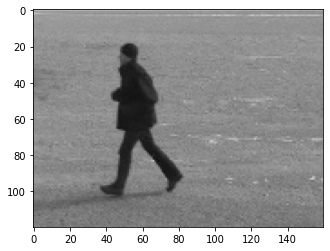

In [93]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: jogging
Predicted class: jogging


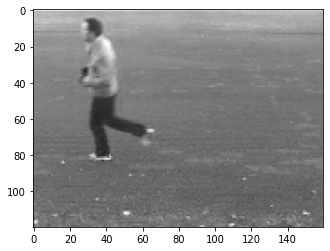

In [94]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: running
Predicted class: running


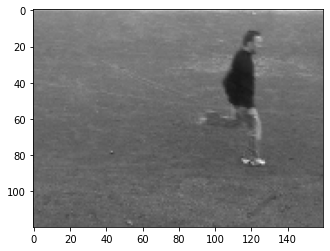

In [95]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: boxing
Predicted class: boxing


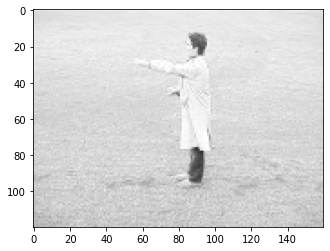

In [96]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: walking
Predicted class: walking


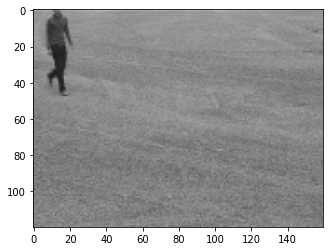

In [97]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])